# Meta model

## Load required modules and functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

from matplotlib_venn import venn2
from tqdm import tqdm

from imblearn.over_sampling import SMOTENC




In [2]:
import pickle

In [3]:
import src.features as features
import src.model_selection as model_selection 
import src.functions as functions
import src.datasets as datasets 

### Settings

In [40]:
# default plt figuresize, smallish
plt.rcParams["figure.figsize"] = (6,3)

## Load and prepare the data

In [4]:
### Load dataset
data = datasets.data_original()
### Feature engineering 
data = features.engineer(data)
### Train test split (unprocessed)
X_, y_ = data.drop('infected', axis=1), data['infected']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, random_state=42, stratify = y_)


### Scaling the data 

In [34]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_)
X_test_scaled = scaler.transform(X_test_)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train_.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test_.columns)



## Load and evaluate all models

In [53]:
models = {}

### Logistic regression

In [55]:
models["Logistic"] = pickle.load(open("models/logistic_RFE9.pkl", "rb"))

In [11]:
n_features = models["Logistic"].coef_.shape[1]
n_features

9

In [47]:
rfe_features = pickle.load(open("models/rfe_features_250103.pkl", "rb"))[9]

In [61]:
print(rfe_features)

['hemo', 'drugs', 'z30', 'race', 'gender', 'offtrt', 'cd420', 'time730', 'time_censored']


### Random Forest

In [63]:
with open("models/random_forest_gridsearch_241218.pkl", "rb") as file:
    models["RandomForest"] = pickle.load(file)

## Evaluate the models

In [64]:

y_train = y_train_
y_test = y_test_

y_pred_train = {}
y_proba_train = {}

y_pred_test = {}
y_proba_test = {}

### Data preprocessing

In [74]:
# by default we assing unscaled raw data to each model
X_train_preprocessed = {modelname: X_train_ for modelname in models}
X_test_preprocessed = {modelname: X_test_ for modelname in models}



In [75]:
# Logistic : scaled dataset, with only selected features
X_train_preprocessed["Logistic"] = X_train_scaled[rfe_features]
X_test_preprocessed["Logistic"] = X_test_scaled[rfe_features]


### Evaluate all models

In [76]:
for model_name in models:
    model = models[model_name]

    X_train = X_train_preprocessed[model_name]
    y_pred_train[model_name] = model.predict(X_train)
    y_proba_train[model_name] = model.predict_proba(X_train)[:,1]

    X_test = X_test_preprocessed[model_name]
    y_pred_test[model_name] = model.predict(X_test)
    y_proba_test[model_name] = model.predict_proba(X_test)[:,1]

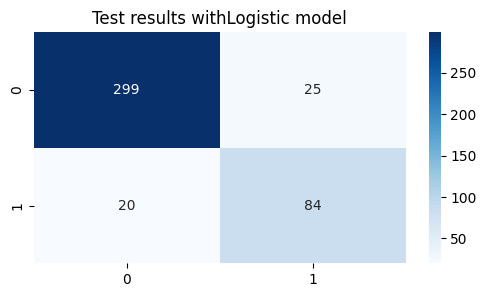

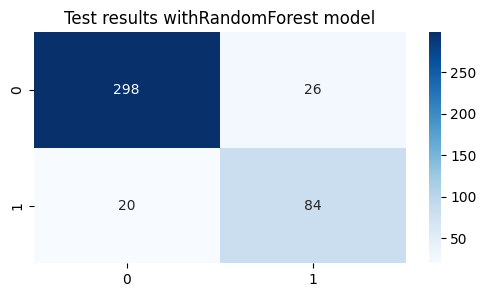

In [ ]:
for model_name in models:
    sns.heatmap(confusion_matrix(y_test,y_pred_test[model_name]), annot = True, cmap = "Blues", fmt='d')
    plt.title("Test results with " + model_name + " model")
    plt.show()


### Evaluation scores


In [85]:
results_test_models_list = []

for model_name in models : 
    y_pred = y_pred_test[model_name]

    results_test = {
        "model": model_name,
        "accuracy": accuracy_score(y_test,y_pred),
        "recall": recall_score(y_test,y_pred),
        "selectivity": recall_score(y_test,y_pred,pos_label = 0),
        "f1": f1_score(y_test,y_pred),
        "f3": fbeta_score(y_test,y_pred,beta = 3),
        "precision": precision_score(y_test,y_pred),
        "NPV": precision_score(y_test,y_pred, pos_label = 0)
    }

    results_test_models_list.append(results_test)

results_test_models_df = pd.DataFrame(results_test_models_list)


In [86]:
print(results_test_models_df)

          model  accuracy    recall  selectivity        f1        f3  \
0      Logistic  0.894860  0.807692     0.922840  0.788732  0.803828   
1  RandomForest  0.892523  0.807692     0.919753  0.785047  0.803059   

   precision       NPV  
0   0.770642  0.937304  
1   0.763636  0.937107  


## Meta model

### Stack the model evaluations

For each patient we evaluate each model with the probability of being infected

In [90]:
X_train_stacked = pd.DataFrame(y_proba_train)
X_test_stacked = pd.DataFrame(y_proba_test)

print(X_train_stacked.shape, X_test_stacked.shape)

(1711, 2) (428, 2)


In [91]:
X_train_stacked.head()

,Logistic,RandomForest
0,0.002483,0.071812
1,0.653643,0.770886
2,0.354624,0.075265
3,0.295284,0.260754
4,0.022432,0.081327


### Visualize the 

### Train the meta model

In [ ]:
Based on the 